In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist, mnist
from IPython.display import clear_output
import copy
import time
import sys
import os

sys.path.append(os.path.join("..", "src"))
import math
import wandb
import argparse
from utils import Loss
from dataloader import load_fashion_mnist, load_mnist
from model import NeuralNet
from optimizer import GradientDescent
import json

In [3]:
with open("../config.json", "r") as f:  # Reading sweep config file
    sweep_config = json.load(f)

wandb_project = "adam_test"
wandb_entity = "adam_test_ce"

wandb.init(
    project=wandb_project,
    name=wandb_entity,
    config=sweep_config,
)



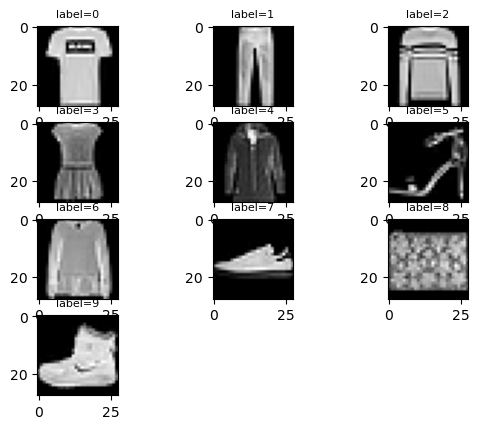

In [4]:
train, valid, test = load_fashion_mnist(sweep_config['batch_size'])


In [5]:
threshold = 1  # Clipping threshold for gradient clipping
loss = Loss(loss_fn=sweep_config["loss"])
optimizer = GradientDescent(
    optimizer=sweep_config["optimizer"],
    lr=sweep_config["learning_rate"],
    clipping_threshold=threshold,
    momentum=sweep_config["momentum"],
    beta=sweep_config["beta"],
    beta1=sweep_config["beta1"],
    beta2=sweep_config["beta2"],
    epsilon=sweep_config["epsilon"],
)
model = NeuralNet(
    input_size=784,
    hidden_size=sweep_config["hidden_size"],
    output_size=10,
    n_hidden=sweep_config["num_layers"],
    loss=loss,
    activation=[sweep_config['activation'], "softmax"],
    weight_init=sweep_config["weight_init"],
    weight_decay=sweep_config["weight_decay"],
)
i = 0

for epoch in range(sweep_config["epochs"]):

    batch_train_loss = []
    batch_valid_loss = []
    batch_train_accuracy = []
    batch_valid_accuracy = []
    start = time.time()

    for x, y in train:
        loss, accuracy = optimizer.optimize(model, x, y, i)
        batch_train_loss.append(loss)
        batch_train_accuracy.append(accuracy)
        wandb.log({"train/batch_loss": loss})

        i += 1

    for x_val, y_val in valid:
        valid_output, valid_loss, valid_accuracy = model(x_val, y_val)
        batch_valid_loss.append(valid_loss)
        batch_valid_accuracy.append(valid_accuracy)

    wandb.log(
        {
            "epoch": epoch + 1,
            "train/loss": np.mean(batch_train_loss),
            "train/accuracy": np.mean(batch_train_accuracy),
            "val/loss": np.mean(batch_valid_loss),
            "val/accuracy": np.mean(batch_valid_accuracy),
        }
    )
    print(
        f"Epoch: {epoch}, Train Loss: {np.mean(batch_train_loss)}, Valid Loss: {np.mean(batch_valid_loss)}, Valid Accuracy: {np.mean(batch_valid_accuracy)}"
    )
    end = time.time()
    print(f"Time taken: {end-start} seconds")


_, _, test_acc = model.predict(test[0], test[1])
wandb.summary["test_accuracy"] = test_acc
print(f"Test Accuracy: {test_acc}")
wandb.finish()


Epoch: 0, Train Loss: 1.3930875269499556, Valid Loss: 0.9127522089967847, Valid Accuracy: 0.7039561170212766
Time taken: 5.594884157180786 seconds
Epoch: 1, Train Loss: 0.7691610390605886, Valid Loss: 0.6958935351189589, Valid Accuracy: 0.761968085106383
Time taken: 5.329599857330322 seconds
Epoch: 2, Train Loss: 0.6353139167395717, Valid Loss: 0.6161610494270837, Valid Accuracy: 0.7928856382978723
Time taken: 5.308880090713501 seconds
Epoch: 3, Train Loss: 0.5752176457441058, Valid Loss: 0.5723340369103057, Valid Accuracy: 0.8050199468085106
Time taken: 5.281318426132202 seconds
Epoch: 4, Train Loss: 0.5398576827036061, Valid Loss: 0.5441333970100456, Valid Accuracy: 0.8113364361702128
Time taken: 5.292194843292236 seconds
Test Accuracy: 0.8053


epoch,▁▃▅▆█
train/accuracy,▁▆▇██
train/batch_loss,█▆▆▄▄▄▃▃▄▃▂▄▂▂▃▁▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▂▁▁▁▁▂
train/loss,█▃▂▁▁
val/accuracy,▁▅▇██
val/loss,█▄▂▂▁
epoch,5
test_accuracy,0.8053
train/accuracy,0.81754
train/batch_loss,0.63689
train/loss,0.53986


In [ ]:
_, _, test_acc = model.predict(test[0], test[1])
